### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)

### Load Composition

In [2]:
data = pd.DataFrame({
    "Name":['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+'],
    "Crit Pres (Psia)":[666.40, 706.50, 616.00, 527.90, 488.60, 453.00, 286],
    "Crit Temp (R)":[343.33, 549.92, 666.06, 765.62, 845.80, 923.00, 728+460],
    "Acentric Factor":[0.01, 0.10, 0.15, 0.19, 0.23, 0.25, 0.5733],
    "Mol Weight":[16.043, 30.07, 44.097, 58.123, 72.15, 84, 260]
})

In [3]:
name = ['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+']
comp = [0.780, 0.065, 0.052, 0.039, 0.026, 0.013, 0.025]
print(sum(comp))

1.0


In [4]:
mw = []
pc = []
tc = []
om = []
for i in range (len(name)):
    mw.append(data[data['Name'] == name[i]]['Mol Weight'].values[0])
    pc.append(data[data['Name'] == name[i]]['Crit Pres (Psia)'].values[0])
    tc.append(data[data['Name'] == name[i]]['Crit Temp (R)'].values[0])
    om.append(data[data['Name'] == name[i]]['Acentric Factor'].values[0])

### Load Well Test Data

In [5]:
welltestdata = pd.read_excel("welltest.xlsx")
p_res = 1313

In [6]:
prodtest = welltestdata.groupby('Rate').min()['Pressure'].reset_index()[1:]
prodtest = prodtest.append({
    'Rate':0,
    'Pressure':p_res
}, ignore_index=True).sort_values(by='Rate').reset_index()[['Rate', 'Pressure']]

In [7]:
prodtest

,Rate,Pressure
0,0,1313.000000
1,1000,1230.071898
2,2000,1139.628224
3,3000,1041.470293
4,4000,933.761492


### Pressure-Squared Calculations

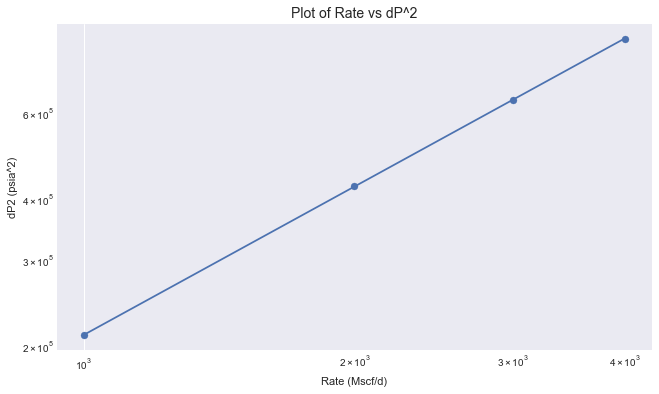

In [8]:
prodtest['dP2'] = p_res**2 - prodtest['Pressure']**2
coef = np.polyfit(np.log(prodtest['Rate'][1:]), np.log(prodtest['dP2'][1:]),1)
n_value_p2 = 1/coef[0]
c_value_p2 = (1/np.exp(coef[1]))**(1/coef[0])
plt.figure(figsize=(16/1.5,9/1.5))
plt.scatter(prodtest['Rate'], prodtest['dP2'])
plt.plot(prodtest['Rate'][1:], np.exp(coef[1])*((prodtest['Rate'][1:])**coef[0]))
plt.xlabel("Rate (Mscf/d)")
plt.ylabel("dP2 (psia^2)")
plt.title("Plot of Rate vs dP^2", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [9]:
aof_psquare = c_value_p2*((p_res**2 - 14.7**2)**n_value_p2)
print("AOFP : ", aof_psquare, " Mscf/d")

AOFP :  8036.015918317042  Mscf/d


### Pseudo-Pressure Calculations

In [10]:
pres = list(prodtest['Pressure'].values)
pres.append(14.7)
temp = 131.3 + 460
r = 10.732

In [11]:
kappa = [0.37464 + 1.54226*i - 0.26992*(i**2) for i in om]
alpha = [(1+kappa[i]*(1-np.sqrt(temp/tc[i])))**2 for i in range (len(kappa))]
ac = [0.45724*((r*tc[i])**2)/pc[i] for i in range (len(name))]
b = [0.07780*r*tc[i]/pc[i] for i in range (len(name))]
aap_mix = 0
b_mix = 0
for i in range (len(name)):
    for j in range (len(name)):
        aap_mix += comp[i]*comp[j]*np.sqrt(ac[i]*ac[j]*alpha[i]*alpha[j])
    b_mix += comp[i]*b[i]
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))

In [12]:
mw_mix = 0
for i in range (len(name)):
    mw_mix += comp[i]*mw[i]
sg = mw_mix/28.97
pc_mix = 709.604 - 58.718*sg
tc_mix = 170.491 + 307.344*sg

In [13]:
bgi = [0.0283*z_fact[i]*temp/pres[i] for i in range (len(pres))]
rhog = [2.7*sg*pres[i]/(z_fact[i]*temp) for i in range (len(pres))]
visg = []
for i in range (len(pres)):
    a_const = (9.379+0.01607*mw_mix)*(temp**1.5)/(209.2+19.26*mw_mix+temp)
    b_const = 3.448 + 986.4/temp + 0.01009*mw_mix
    c_const = 2.447 - 0.2224*b_const
    visg.append(a_const*np.exp(b_const*((rhog[i]/62.428)**c_const))/1e4)

In [14]:
pseudo_pressure = pd.DataFrame({
    "A":pres,
    "B":z_fact,
    "C":visg
})

In [15]:
pseudo_pressure['D'] = 2*pseudo_pressure['A']/(pseudo_pressure['B']*pseudo_pressure['C'])
E = []
for i in range (len(pseudo_pressure['D'].values)):
    if (i==0):
        E.append((pseudo_pressure['D'].values[i])/2)
    else:
        E.append((pseudo_pressure['D'].values[i] + pseudo_pressure['D'].values[i-1])/2)        
pseudo_pressure['E'] = E
F = []
for i in range (len(pseudo_pressure['A'].values)):
    if (i==0):
        F.append(pseudo_pressure['A'].values[i])
    else:
        F.append(pseudo_pressure['A'].values[i] - pseudo_pressure['A'].values[i-1])        
pseudo_pressure['F'] = F
pseudo_pressure['G'] = pseudo_pressure['E']*pseudo_pressure['F']
H = []
for i in range (len(pseudo_pressure['G'].values)):
    if (i==0):
        H.append(pseudo_pressure['G'].values[i])
    else:
        H.append(pseudo_pressure['G'].values[i] + H[i-1])
pseudo_pressure['H'] = H

In [16]:
prodtest['Pseudo_Pressure'] = pseudo_pressure['H'][:-1]

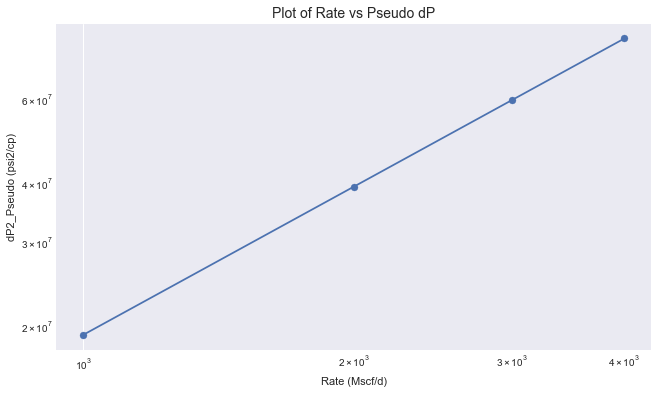

In [17]:
prodtest['dP_Pseudo'] = prodtest['Pseudo_Pressure'].values[0] - prodtest['Pseudo_Pressure'] 
coef = np.polyfit(np.log(prodtest['Rate'][1:]), np.log(prodtest['dP_Pseudo'][1:]),1)
n_value = 1/coef[0]
c_value = (1/np.exp(coef[1]))**(1/coef[0])
plt.figure(figsize=(16/1.5,9/1.5))
plt.scatter(prodtest['Rate'], prodtest['dP_Pseudo'])
plt.plot(prodtest['Rate'][1:], np.exp(coef[1])*((prodtest['Rate'][1:])**coef[0]))
plt.xlabel("Rate (Mscf/d)")
plt.ylabel("dP2_Pseudo (psi2/cp)")
plt.title("Plot of Rate vs Pseudo dP", fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
aof_pseudo = c_value*((pseudo_pressure['H'].values[0] - pseudo_pressure['H'].values[-1])**n_value)
print("AOFP : ", aof_pseudo, " Mscf/d")

AOFP :  8083.438095152944  Mscf/d


Based on the calculation between pseudo-pressure approach and pressure-squared approach, they both gives AOFP about 8 MMSCF/d, with error about 47 Mscf, this error is relatively low because the pressure of the test are below 2000 psia

### Rate Predictions Case #1

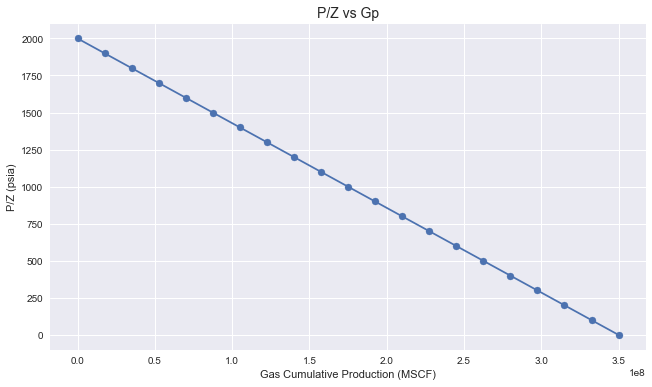

In [19]:
igip = 350000000
coef_pz = np.polyfit([0, igip], [pres[0]/z_fact[0], 0], deg=1)
p_over_z = [i for i in range (0,int(pres[0]/z_fact[0]),100)]
p_over_z.append(pres[0]/z_fact[0])
gp = [(pz - coef_pz[1])/coef_pz[0] for pz in p_over_z]
plt.figure(figsize=(16/1.5,9/1.5))
plt.plot(gp, p_over_z)
plt.scatter(gp, p_over_z)
plt.xlabel('Gas Cumulative Production (MSCF)')
plt.ylabel('P/Z (psia)')
plt.title('P/Z vs Gp', fontsize=14)
plt.show()

In [20]:
q_plateu = 2500 
pwf_min = 250
p_res_minimum = np.sqrt((q_plateu/c_value_p2)**(1/n_value_p2) + pwf_min**2)

In [21]:
pres = [p_res_minimum]

In [22]:
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))
z_fact_minimum = z_fact[0]

In [23]:
p_per_z_minimum = p_res_minimum/z_fact_minimum
gp_at_minimum = (p_per_z_minimum - coef_pz[1])/coef_pz[0]
gpmincase1 = gp_at_minimum
t_plateu = gp_at_minimum/q_plateu
print("Plateu Time : ", t_plateu/365, " years")

Plateu Time :  192.83530807317337  years


In [24]:
pres_array = [i for i in range (p_res, int(p_res_minimum), -1)]
pres_array.append(p_res_minimum)
pwf_array = [np.sqrt(p**2 - (q_plateu/c_value_p2)**(1/n_value_p2)) for p in pres_array]
qg_array = [q_plateu]*len(pwf_array)
delta_time = t_plateu/len(pwf_array)
time_array = [i*delta_time for i in range (1, len(pwf_array)+1)]

In [25]:
qg_tmin1 = q_plateu
qg_t = q_plateu
gp_prod = gp_at_minimum
pressure = p_res_minimum
time = t_plateu
delta_gp = 1000000
while pressure >= pwf_min:
    gp_prod += delta_gp
    p_per_z = gp_prod*coef_pz[0] + coef_pz[1]
    error = 1000
    pressure = p_per_z
    while (error > 1e-1):
        a_val = aap_mix*pressure/((r*temp)**2)
        b_val = b_mix*pressure/(r*temp)
        coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
        roots = np.roots(coef)
        zfactor = np.max(roots.real)
        error = abs(p_per_z*zfactor - pressure)
        pressure = p_per_z*zfactor
    if (pressure < pwf_min):
        break
    qg_t  = c_value_p2*((pressure**2 - pwf_min**2)**n_value_p2)
    delta_time = delta_gp/(0.5*(qg_t+qg_tmin1))
    qg_tmin1 = qg_t
    time += delta_time
    pres_array.append(pressure)
    pwf_array.append(pwf_min)
    qg_array.append(qg_t)
    time_array.append(time)

### Rate Prediction Result

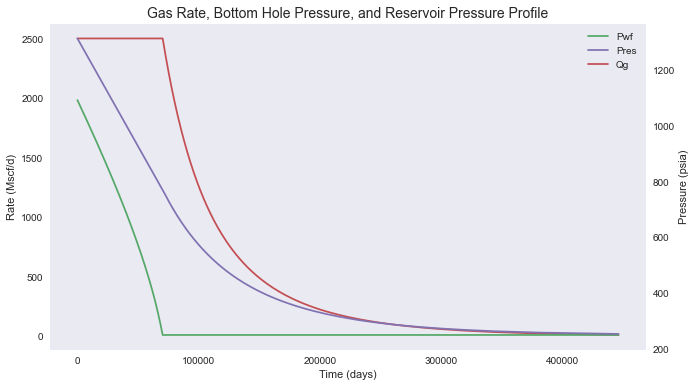

In [26]:
fig, ax = plt.subplots(figsize=(16/1.5,9/1.5))
fig.patch.set_alpha(0)
ax1 = ax.twinx()
pwfplot = ax1.plot(time_array, pwf_array, label='Pwf', color='#55a868')
presplot = ax1.plot(time_array, pres_array, label='Pres', color='#8172b2')
qgplot = ax.plot(time_array, qg_array, label='Qg', color='#c44e52')
ratecase1 = qg_array
timecase1 = time_array
ax.grid(False)
ax1.grid(False)
ax1.set_ylabel("Pressure (psia)")
ax.set_ylabel("Rate (Mscf/d)")
ax.set_xlabel("Time (days)")
lns = pwfplot+presplot+qgplot
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1, 1), loc=1)
plt.title("Gas Rate, Bottom Hole Pressure, and Reservoir Pressure Profile", fontsize=14)
plt.show()

### Rate Prediction Case #2

In [27]:
q_plateu = 10
t_plateu = 9999
while (round(t_plateu) >= 15):
    pwf_min = 250
    p_res_minimum = np.sqrt((q_plateu/c_value_p2)**(1/n_value_p2) + pwf_min**2)
    pres = [p_res_minimum]
    z_fact = []
    for p in pres:
        a_val = aap_mix*p/((r*temp)**2)
        b_val = b_mix*p/(r*temp)
        coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
        roots = np.roots(coef)
        z_fact.append(np.max(roots.real))
    z_fact_minimum = z_fact[0]
    p_per_z_minimum = p_res_minimum/z_fact_minimum
    gp_at_minimum = (p_per_z_minimum - coef_pz[1])/coef_pz[0]
    t_plateu = gp_at_minimum/q_plateu
    t_plateu = t_plateu/365
    if (t_plateu <= 15):
        break
    q_plateu += 1
print("Plateu rate : ", q_plateu, " MSCFD")

Plateu rate :  6536  MSCFD


In [28]:
pwf_min = 250
p_res_minimum = np.sqrt((q_plateu/c_value_p2)**(1/n_value_p2) + pwf_min**2)

In [29]:
pres = [p_res_minimum]

In [30]:
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))
z_fact_minimum = z_fact[0]

In [31]:
p_per_z_minimum = p_res_minimum/z_fact_minimum
gp_at_minimum = (p_per_z_minimum - coef_pz[1])/coef_pz[0]
gpmincase1 = gp_at_minimum
t_plateu = gp_at_minimum/q_plateu
print("Plateu Time : ", t_plateu/365, " years")

Plateu Time :  14.985615644576143  years


In [32]:
pres_array = [i for i in range (p_res, int(p_res_minimum), -1)]
pres_array.append(p_res_minimum)
pwf_array = [np.sqrt(p**2 - (q_plateu/c_value_p2)**(1/n_value_p2)) for p in pres_array]
qg_array = [q_plateu]*len(pwf_array)
delta_time = t_plateu/len(pwf_array)
time_array = [i*delta_time for i in range (1, len(pwf_array)+1)]

In [33]:
qg_tmin1 = q_plateu
qg_t = q_plateu
gp_prod = gp_at_minimum
pressure = p_res_minimum
time = t_plateu
delta_gp = 1000000
while pressure >= pwf_min:
    gp_prod += delta_gp
    p_per_z = gp_prod*coef_pz[0] + coef_pz[1]
    error = 1000
    pressure = p_per_z
    while (error > 1e-1):
        a_val = aap_mix*pressure/((r*temp)**2)
        b_val = b_mix*pressure/(r*temp)
        coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
        roots = np.roots(coef)
        zfactor = np.max(roots.real)
        error = abs(p_per_z*zfactor - pressure)
        pressure = p_per_z*zfactor
    if (pressure < pwf_min):
        break
    qg_t  = c_value_p2*((pressure**2 - pwf_min**2)**n_value_p2)
    delta_time = delta_gp/(0.5*(qg_t+qg_tmin1))
    qg_tmin1 = qg_t
    time += delta_time
    pres_array.append(pressure)
    pwf_array.append(pwf_min)
    qg_array.append(qg_t)
    time_array.append(time)

### Rate Prediction Result

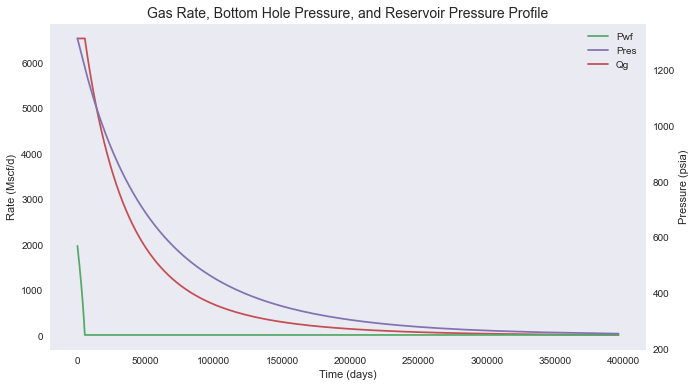

In [34]:
fig, ax = plt.subplots(figsize=(16/1.5,9/1.5))
fig.patch.set_alpha(0)
ax1 = ax.twinx()
pwfplot = ax1.plot(time_array, pwf_array, label='Pwf', color='#55a868')
presplot = ax1.plot(time_array, pres_array, label='Pres', color='#8172b2')
qgplot = ax.plot(time_array, qg_array, label='Qg', color='#c44e52')
ratecase2 = qg_array
timecase2 = time_array
ax.grid(False)
ax1.grid(False)
ax1.set_ylabel("Pressure (psia)")
ax.set_ylabel("Rate (Mscf/d)")
ax.set_xlabel("Time (days)")
lns = pwfplot+presplot+qgplot
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1, 1), loc=1)
plt.title("Gas Rate, Bottom Hole Pressure, and Reservoir Pressure Profile", fontsize=14)
plt.show()

### Rate and Cumulative Comparison

In [35]:
gp1_array = []
gpcase1 = ratecase1[0]*(timecase1[0])
gp1_array.append(gpcase1)
for i in range (1,len(timecase1)):
    gpcase1 += ratecase1[i]*(timecase1[i] - timecase1[i-1])
    gp1_array.append(gpcase1)
gp2_array = []
gpcase2 = ratecase2[0]*(timecase2[0])
gp2_array.append(gpcase2)
for i in range (1,len(timecase2)):
    gpcase2 += ratecase2[i]*(timecase2[i] - timecase2[i-1])
    gp2_array.append(gpcase2)
for i in range (len(gp1_array)):
    gp1_array[i] = gp1_array[i]/1000000
for i in range (len(gp2_array)):
    gp2_array[i] = gp2_array[i]/1000000

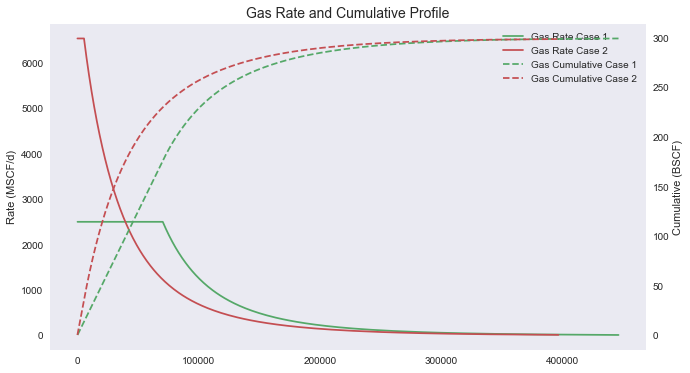

In [36]:
fig, ax = plt.subplots(figsize=(16/1.5,9/1.5))
fig.patch.set_alpha(0)
ax1 = ax.twinx()
qg1plot = ax.plot(timecase1, ratecase1,label='Gas Rate Case 1', color='#55a868')
qg2plot = ax.plot(timecase2, ratecase2,label='Gas Rate Case 2', color='#c44e52')
gp1plot = ax1.plot(timecase1, gp1_array,'--',label='Gas Cumulative Case 1', color='#55a868')
gp2plot = ax1.plot(timecase2, gp2_array,'--',label='Gas Cumulative Case 2', color='#c44e52')
ax.grid(False)
ax1.grid(False)
ax.set_ylabel("Rate (MSCF/d)")
ax1.set_ylabel("Cumulative (BSCF)")
ax1.set_xlabel("Time (days)")
lns = qg1plot + qg2plot + gp1plot + gp2plot
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1, 1), loc=0)
plt.title("Gas Rate and Cumulative Profile", fontsize=14)
plt.show()